In [1]:
from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings


cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'


In [2]:
out = np.load("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/intermediate_processed_data/hs_data.npz", allow_pickle=True)

In [3]:

t_apex = out['t_apex']
Hs_corr = out['Hs_corr']
swift_arr=out['swift_arr']
swift_t = out['swift_t']
ts = out['ts']
Hs_cdip = out['Hs_cdip']
errors = out['errors']
loc_store_sorted = out['loc_store_sorted']

Te_cdip = out['Te_cdip']
Te = out['Te']
peak_freq = out['peak_freq']
peak_freq_cdip = out['peak_freq_cdip']

In [20]:
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) 
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])

nc.close()

In [21]:
swift_heights_store = np.ones((75, len(t_apex)))*np.nan

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28669/1410324038.py:108: RuntimeWarning: Mean of empty slice
  swift_mean_spec_store = np.nanmean(spec_array[blah[0], :], axis=0)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_28669/1410324038.py:110: RuntimeWarning: Mean of empty slice
  swift_mean_spec_store = np.vstack((swift_mean_spec_store, np.nanmean(spec_array[blah[0], :], axis=0)))


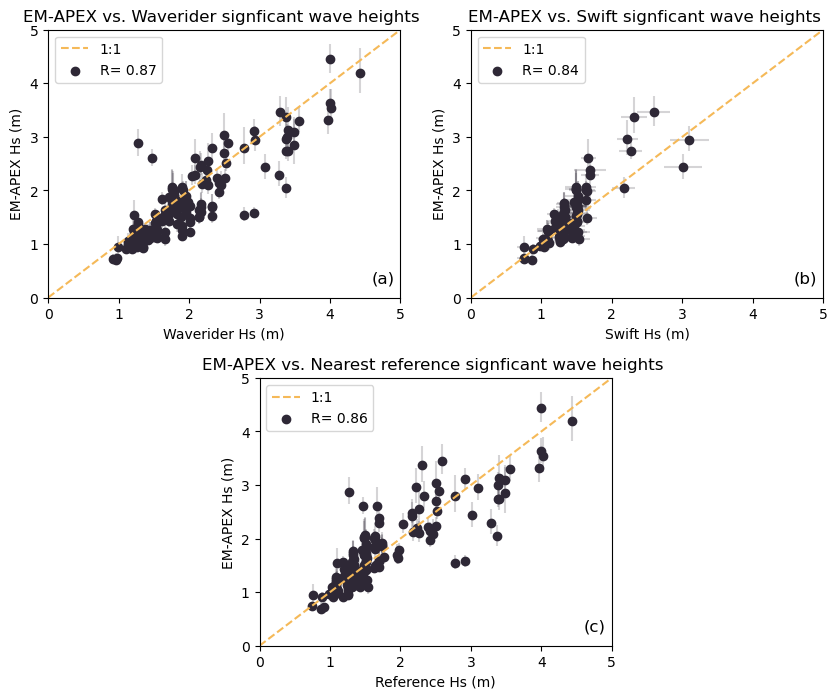

In [104]:
#Load SWIFT Data
##TO DO: Get distances for each thing


cdip_inds = np.array([], dtype=int)
for ind in range(0, len(t_apex)):
    ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds = np.append(cdip_inds, ind2[0])

    
all_swift_file = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/testswiftnew.mat"

SWIFT_new = loadmat(all_swift_file)
swift_arr = np.array([[0,0,0,0,0,0,0]])
spec_array = np.array([])
for i in range(len(SWIFT_new['swift'][0, 0])):
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_temp = SWIFT_new['swift'][0, 0][i]
    #time = swift_temp[0, 0][0][0]
    #lon = swift_temp[0, 0][1][0]
    #lat = swift_temp[0, 0][2][0]
    #wavesigH = swift_temp[0, 0][9][0]
    mdtype = swift_temp.dtype
    ndata = {n: swift_temp[n] for n in mdtype.names}
    columns = [n for (n, v) in ndata.items()]
    df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
    lat=np.array(df['lat'][0], dtype=float).T
    lon=np.array(df['lon'][0], dtype=float).T
    time = np.array(df['time'][0], dtype=float).T
    hs = np.array(df['wavesigH'][0], dtype=float).T
    wave_dir = np.array(df['wavepeakdir'][0], dtype=float).T
    peak_T = np.array(df['wavepeakT'][0], dtype=float).T
    #lat_arr = np.expand_dims(lat, axis=1)
    #lon_arr = np.expand_dims(lon, axis=1)
    #time_arr = np.expand_dims(time, axis=1)
    #hs_arr = np.expand_dims(hs, axis=1)

    wave_spec = swift_temp['wavepower'][0, 0]
    #wave_spec[np.where(np.isnan(wave_spec))] = 0
    if len(spec_array) == 0:
        spec_array = wave_spec.T
    else:
        spec_array = np.vstack((spec_array, wave_spec.T))
    
    start_f = 0.03
    cutoff_freq = 0.2

    swift_freq = swift_temp['wavefreq'][0, 0][:, 0]
    end_f = np.where(swift_freq<cutoff_freq)[-1][-1]
    start_f = np.where(swift_freq>start_f)[0][0]
    spec_t = wave_spec[start_f:end_f].T
    swift_freq_t = swift_freq[start_f:end_f]
    #spec_t[np.where(np.isnan(spec_t))] = 0
    
    #swift_freq_t = np.tile(swift_freq_t
    #swift_freq_t = np.tile(swift_freq_t, (spec_t.shape[0], 1))
    Te_temp = np.array([])
    for spec_i in range(spec_t.shape[0]):
        Te_temp = np.append(Te_temp, np.trapz(spec_t[spec_i, ~np.isnan(spec_t[spec_i, :])], x=swift_freq_t[~np.isnan(spec_t[spec_i, :])])/np.trapz(swift_freq_t[~np.isnan(spec_t[spec_i, :])]*spec_t[spec_i, ~np.isnan(spec_t[spec_i, :])], x=swift_freq_t[~np.isnan(spec_t[spec_i, :])]))
    #Te_swift_store = np.append(Te_swift_store, Te_temp)
    Te_temp = np.expand_dims(Te_temp, (1))
    swift_temp_arr = np.hstack((time, lon, lat, hs, wave_dir, peak_T, Te_temp))
    swift_arr = np.vstack((swift_arr, swift_temp_arr))

    
    

swift_arr = np.delete(swift_arr, 0, 0)

spec_arr = spec_array[swift_arr[:, 0].argsort()]
#swift_arr2=swift_arr2[swift_arr[:, 0].argsort()]
swift_arr = swift_arr[swift_arr[:, 0].argsort()]

swift_t_out=datenum_to_datetime(swift_arr[:, 0])
swift_mean_store = np.array([], dtype=int)
swift_mean_T_store = np.array([], dtype=int)
swift_mean_T_store_self = np.array([], dtype=int)
swift_std_store = np.array([], dtype=int)
apex_swift_inds = np.array([], dtype=int)
swift_dists = np.array([], dtype=int)
swift_mean_lat = np.array([], dtype=int)
swift_mean_lon = np.array([], dtype=int)
swift_mean_spec_store = np.array([], dtype=int)
counter = 0
for t in t_apex:
    blah = np.where(np.abs(t-swift_t_out)<datetime.timedelta(hours=1))
    if blah[0].size==0:
        counter+=1
        continue
    else:
        ind = np.where(t==t_apex)
        #lat = loc_store_sorted[ind, 0]
        #lon = loc_store_sorted[ind, 1]
        swift_mean_store = np.append(swift_mean_store, np.nanmean(swift_arr[blah, 3]))
        swift_mean_T_store = np.append(swift_mean_T_store, np.nanmean(swift_arr[blah, 5]))
        swift_mean_T_store_self = np.append(swift_mean_T_store_self, np.nanmean(swift_arr[blah, 6]))


        swift_std_store = np.append(swift_std_store, np.nanstd(swift_arr[blah, 3]))
        swift_heights_store[:len(blah[0]), counter] = swift_arr[blah, 3]
        swift_mean_lat = np.append(swift_mean_lat, np.nanmean(swift_arr[blah, 2]))
        swift_mean_lon = np.append(swift_mean_lon, np.nanmean(swift_arr[blah, 1]))

        
        if len(swift_mean_spec_store) == 0:
            swift_mean_spec_store = np.nanmean(spec_array[blah[0], :], axis=0)
        else:
            swift_mean_spec_store = np.vstack((swift_mean_spec_store, np.nanmean(spec_array[blah[0], :], axis=0)))
        #swift_mean_spec_store = np.append(swift_mean_spec_store, np.nanmean(spec_array[blah, :], axis=0))

        #swift_inds_store = np.append()
        #print(len(blah[0]))
        #dists = np.zeros(len(blah[0]))
        #for blah_i in range(len(blah[0])):
        #    dists[blah_i] = np.array(haversine.haversine((lat, lon), (swift_arr[blah[0][blah_i], 2], swift_arr[blah[0][blah_i], 1]), normalize=True, unit=haversine.Unit.KILOMETERS))

        #swift_dists = np.append(swift_dists, np.nanmin(dists))
        apex_swift_inds = np.append(apex_swift_inds, counter)
    counter+=1
    

    
#Calculate distances to SWIFT
#Get distances from buoy to floats
swift_dist=np.array([])
cdip_dist = np.array([])
import haversine
for ind in range(len(apex_swift_inds)):
    lat = loc_store_sorted[apex_swift_inds[ind], 0]
    lon = loc_store_sorted[apex_swift_inds[ind], 1]
    #if lat==0:
    #    continue
    #In meters
    swift_dist = np.append(swift_dist, np.array(haversine.haversine((lat, lon), (swift_mean_lat[ind], swift_mean_lon[ind]-360), normalize=True, unit=haversine.Unit.KILOMETERS)))
    
for ind in range(len(Hs_corr)):
    lat = loc_store_sorted[ind, 0]
    lon = loc_store_sorted[ind, 1]
    #if lat==0:
    #    continue
    #In meters
    cdip_dist = np.append(cdip_dist, np.array(haversine.haversine((lat, lon), (cdip_lat, cdip_lon), normalize=True, unit=haversine.Unit.KILOMETERS)))
    
    
    
#Calculate some fits 
x=np.arange(0, 6, 0.1)
[coef, resid, rank, sing, rcond] = np.polyfit(Hs_cdip[cdip_inds], Hs_corr,1, full=True)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

#'--k'=black dashed line, 'yo' = yellow circle marker    
    
#Calculate Pearson R value
cdip_R = np.corrcoef(Hs_cdip[cdip_inds], Hs_corr)
swift_R = np.corrcoef(swift_mean_store, Hs_corr[apex_swift_inds])
    
    
#Plot the EM-APEX vs. Swift data
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
#gs = gridspec.GridSpec(1, 2)

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
gs.update(hspace=0.3)
plt.figure(figsize=(10,8))
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

#plt.figure(figsize=(15,5))



#plt.subplot(121)
#ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1.errorbar(Hs_cdip[cdip_inds], Hs_corr, yerr = errors, c=gray_color, alpha=0.2, fmt='none')
ax1.scatter(Hs_cdip[cdip_inds], Hs_corr, c=gray_color, label="R= "+"{:.2f}".format( cdip_R[0, 1] ))


y = np.arange(0, 6, 0.1)
ax1.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
ax1.set_xlim([0, 5])
ax1.set_ylim([0, 5])
ax1.set_xlabel("Waverider Hs (m)")
ax1.set_ylabel("EM-APEX Hs (m)")
ax1.set_title("EM-APEX vs. Waverider signficant wave heights ")
ax1.legend()




swift_arr = swift_arr[swift_arr[:, 0].argsort()]
cdip_timestamp = [temp_t.timestamp() for temp_t in ts]
swift_timestamp = [s_temp.timestamp() for s_temp in datenum_to_datetime(swift_arr[:, 0])]

Hs_cdip_interped = np.interp(swift_timestamp, cdip_timestamp, Hs_cdip)

#Only include if <10km distance
keep_inds = np.where(swift_dist<10)


swift_R_modified = np.corrcoef(swift_mean_store[keep_inds], Hs_corr[apex_swift_inds[keep_inds]])

ax2.errorbar(swift_mean_store[keep_inds], Hs_corr[apex_swift_inds[keep_inds]], yerr = errors[:, apex_swift_inds[keep_inds]], xerr=swift_std_store[keep_inds], color=gray_color, alpha=0.2, fmt='none')
ax2.scatter(swift_mean_store[keep_inds], Hs_corr[apex_swift_inds[keep_inds]], color=gray_color, label="R= "+"{:.2f}".format( swift_R_modified[0, 1] ))
#im = ax.scatter(swift_mean_store, Hs_corr[apex_swift_inds], c=cdip_apex_diff, cmap="magma")


y = np.arange(0, 6, 0.1)
ax2.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
ax2.set_xlim([0, 5])
ax2.set_ylim([0, 5])
ax2.set_xlabel("Swift Hs (m)")
ax2.set_ylabel("EM-APEX Hs (m)")
ax2.set_title("EM-APEX vs. Swift signficant wave heights ")
ax2.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Hs_scatter.png")



# #Try doing one thing, but picking cdip or swift based on which is closer
ref_vals = []
cdip_counter = 0
Hs_to_compare_w_ref = []
for ind in range(len(Hs_corr)):
    if ind in apex_swift_inds:
        swift_dist_ind = np.where(ind==apex_swift_inds)
        if cdip_dist[ind] < swift_dist[swift_dist_ind[0][0]]:
            #if cdip_dist[ind]<10:
            ref_vals = np.append(ref_vals, Hs_cdip[cdip_inds[ind]])
            #Hs_to_compare_w_ref = np.append(Hs_to_compare_w_ref, Hs_corr[ind])
            cdip_counter += 1
        else:
            #if swift_dist[swift_dist_ind[0][0]]<10:
            ref_vals = np.append(ref_vals, swift_mean_store[swift_dist_ind[0][0]])
            #Hs_to_compare_w_ref = np.append(Hs_to_compare_w_ref, Hs_corr[ind])
    else:
        #if cdip_dist[ind]<10:
        ref_vals = np.append(ref_vals, Hs_cdip[cdip_inds[ind]])
        #Hs_to_compare_w_ref = np.append(Hs_to_compare_w_ref, Hs_corr[ind])
        cdip_counter+=1
        
#cdip_inds = np.where(swift_dist<)
#plt.figure()
#plt.subplot(122)
#ax = plt.subplot(gs[0, 1]) # row 0, col 1

swift_R_modified2 = np.corrcoef(ref_vals, Hs_corr)

ax3.errorbar(ref_vals, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
ax3.scatter(ref_vals, Hs_corr, color=gray_color, label="R= "+"{:.2f}".format( swift_R_modified2[0, 1] ))
#im = ax.scatter(swift_mean_store, Hs_corr[apex_swift_inds], c=cdip_apex_diff, cmap="magma")


y = np.arange(0, 6, 0.1)
ax3.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
ax3.set_xlim([0, 5])
ax3.set_ylim([0, 5])
ax3.set_xlabel("Reference Hs (m)")
ax3.set_ylabel("EM-APEX Hs (m)")
ax3.set_title("EM-APEX vs. Nearest reference signficant wave heights ")
ax3.legend()

ax1.annotate(text='(a)', xy=(4.75, 0.27), fontsize=12, ha="center")
ax2.annotate(text='(b)', xy=(4.75, 0.27), fontsize=12, ha="center")
ax3.annotate(text='(c)', xy=(4.75, 0.27), fontsize=12, ha="center")


#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Hs_reference_vals_scatter.png")

In [23]:
# Calculate RMS errors

combined_rms = np.sqrt(np.sum(np.square(Hs_corr-ref_vals))/len(Hs_corr))
combined_bias = np.nanmean(Hs_corr-ref_vals)
print("combined rms ", combined_rms)
print("combined bias ", combined_bias)

##CDDIP RMS

cdip_rms = np.sqrt(np.sum(np.square(Hs_corr-Hs_cdip[cdip_inds]))/len(Hs_corr))
cdip_bias = np.nanmean(Hs_corr-Hs_cdip[cdip_inds])
print("cdip rms ", cdip_rms)
print("cdip bias ", cdip_bias)

##SWIFT RMS
, 
swift_rms = np.sqrt(np.sum(np.square(Hs_corr[apex_swift_inds[keep_inds]]-swift_mean_store[keep_inds]))/len(Hs_corr[apex_swift_inds[keep_inds]]))
swift_bias = np.nanmean(Hs_corr[apex_swift_inds[keep_inds]]-swift_mean_store[keep_inds])
print("swift rms ", swift_rms)
print("swift bias ", swift_bias)

combined rms  0.402185188817731
combined bias  0.022362898241051612
cdip rms  0.41401058345788905
cdip bias  -0.18232462088199755
swift rms  0.32253065503586004
swift bias  0.11986382488624317


In [8]:
#Calculate  Te based on mean spectra -- maybe improves SNR?
#start_f = 2
#end_f = 18

new_calc_T = np.array([])
for ind in range(len(swift_mean_spec_store[:, 0])):
    swift_mean_spec_store[ind, np.where(np.isnan(swift_mean_spec_store[ind, :]))]=0
   # plt.loglog(swift_freq, swift_mean_spec_store[ind, :])
    #plt.vlines(x=1/swift_mean_T_store_self[ind], ymin=0, ymax=10)
    num = np.trapz(swift_mean_spec_store[ind, start_f:end_f], x=swift_freq[start_f:end_f])
    denom = np.trapz(swift_freq[start_f:end_f]*swift_mean_spec_store[ind, start_f:end_f], x=swift_freq[start_f:end_f])
    new_calc = num/denom
    new_calc_T = np.append(new_calc_T, new_calc)
    #plt.vlines(x=1/new_calc, ymin=0, ymax=10, color='orange')

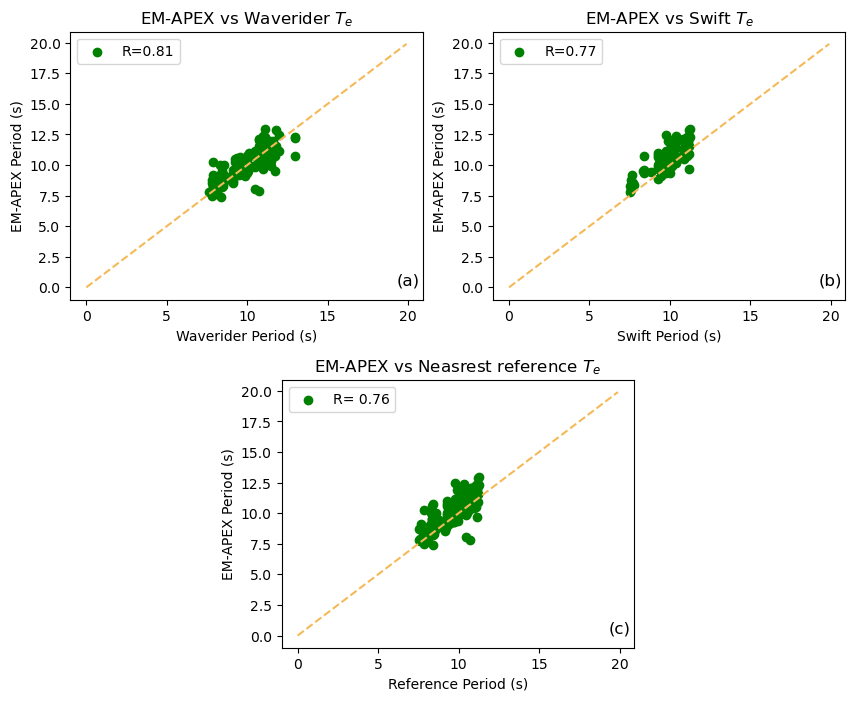

In [112]:
### DO THE SAME FOR PERIOD MEASUREMENTS


import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
gs.update(hspace=0.3)
plt.figure(figsize=(10,8))
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

#Get corr coefficients
Te_R = np.corrcoef(Te_cdip[cdip_inds], Te)[0, 1]
peak_R = np.corrcoef(1/peak_freq_cdip[cdip_inds], 1/peak_freq)[0, 1]


ax1.scatter(Te_cdip[cdip_inds], Te, color='g', label="R=" + str(round(Te_R, 2)))
#plt.scatter(1/peak_freq_cdip[cdip_inds], 1/peak_freq, color='k', label=r"$T_{p}$, R="+str(round(peak_R, 2)))
#plt.scatter(Te_cdip[cdip_inds], Te, color='g', label="No cutoff")

y = np.arange(0, 20, 0.1)
ax1.plot(np.arange(0, 20, 0.1), y, '--', color=cdip_color)
ax1.set_xlabel("Waverider Period (s)")
ax1.set_ylabel("EM-APEX Period (s)")
ax1.set_title(r"EM-APEX vs Waverider $T_{e}$")
ax1.legend()
#ax.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Frequency_plot.png", bbox_inches='tight')



swift_peak_f = get_peak_freq(swift_freq, spec_arr)[0]
#Get correlations w/ swift
peak_swift_R = np.corrcoef(1/swift_peak_f[keep_inds], 1/peak_freq[apex_swift_inds[keep_inds]])[0, 1]
Te_swift_R = np.corrcoef(swift_mean_T_store_self[keep_inds], Te[apex_swift_inds[keep_inds]])[0, 1]

#swift_peak_f[swift_peak_f<0.01]=np.nan
#plt.scatter(swift_mean_T_store[keep_inds], 1/peak_freq[apex_swift_inds[keep_inds]], color='k')
#plt.scatter(swift_mean_T_store[keep_inds], Te[apex_swift_inds[keep_inds]], color='k')
ax2.scatter(swift_mean_T_store_self[keep_inds], Te[apex_swift_inds[keep_inds]], color='g', label="R="+str(round(Te_swift_R, 2)))

#plt.scatter(1/swift_peak_f[keep_inds], 1/peak_freq[apex_swift_inds[keep_inds]], color='k', label=r"$T_{p}$, R=" + str(round(peak_swift_R, 2)))
ax2.legend()
ax2.set_xlabel("Swift Period (s)")
ax2.set_ylabel("EM-APEX Period (s)")
ax2.set_title(r"EM-APEX vs Swift $T_{e}$")

#plt.scatter(swift_mean_T_store[keep_inds], 1/peak_freq[apex_swift_inds[keep_inds]], color='orange')
#plt.scatter(new_calc_T[keep_inds], Te[apex_swift_inds[keep_inds]], color='r')

y = np.arange(0, 20, 0.1)
ax2.plot(np.arange(0, 20, 0.1), y, '--', color=cdip_color)


# #Try doing one thing, but picking cdip or swift based on which is closer
ref_vals_Te = []
cdip_counter = 0
#Te_to_compare_w_ref = []
for ind in range(len(Te)):
    if ind in apex_swift_inds:
        swift_dist_ind = np.where(ind==apex_swift_inds)
        if cdip_dist[ind] < swift_dist[swift_dist_ind[0][0]]:
            #if cdip_dist[ind]<10:
            ref_vals_Te = np.append(ref_vals_Te, Te_cdip[cdip_inds[ind]])
            #Hs_to_compare_w_ref = np.append(Hs_to_compare_w_ref, Hs_corr[ind])
            cdip_counter += 1
        else:
            #if swift_dist[swift_dist_ind[0][0]]<10:
            ref_vals_Te = np.append(ref_vals_Te, swift_mean_T_store_self[swift_dist_ind[0][0]])
            #Hs_to_compare_w_ref = np.append(Hs_to_compare_w_ref, Hs_corr[ind])
    else:
        #if cdip_dist[ind]<10:
        ref_vals_Te = np.append(ref_vals_Te, Te_cdip[cdip_inds[ind]])
        #Hs_to_compare_w_ref = np.append(Hs_to_compare_w_ref, Hs_corr[ind])
        cdip_counter+=1
        
swift_R_modified_T = np.corrcoef(ref_vals_Te, Te)

#ax3.errorbar(ref_vals, Te, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
ax3.scatter(ref_vals_Te, Te, color='g', label="R= "+"{:.2f}".format(swift_R_modified_T[0, 1] ))
#im = ax.scatter(swift_mean_store, Hs_corr[apex_swift_inds], c=cdip_apex_diff, cmap="magma")
y = np.arange(0, 20, 0.1)
ax3.plot(np.arange(0, 20, 0.1), y, '--', color=cdip_color)
ax3.legend()
ax3.set_xlabel("Reference Period (s)")
ax3.set_ylabel("EM-APEX Period (s)")
ax3.set_title(r"EM-APEX vs Neasrest reference $T_{e}$")



ax1.annotate(text='(a)', xy=(20, 0.2), fontsize=12, ha="center")
ax2.annotate(text='(b)', xy=(20, 0.2), fontsize=12, ha="center")
ax3.annotate(text='(c)', xy=(20, 0.2), fontsize=12, ha="center")





#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Te_reference_vals_scatter.png")


In [113]:
combined_rms = np.sqrt(np.sum(np.square(Te-ref_vals_Te))/len(Te))
combined_bias = np.nanmean(Te-ref_vals_Te)
print("combined rms ", combined_rms)
print("combined bias ", combined_bias)

##CDDIP RMS

cdip_rms = np.sqrt(np.sum(np.square(Te-Te_cdip[cdip_inds]))/len(Te))
cdip_bias = np.nanmean(Te-Te_cdip[cdip_inds])
print("cdip rms ", cdip_rms)
print("cdip bias ", cdip_bias)

##SWIFT RMS

swift_rms = np.sqrt(np.sum(np.square(Te[apex_swift_inds[keep_inds]]-swift_mean_T_store_self[keep_inds]))/len(Te[apex_swift_inds[keep_inds]]))
swift_bias = np.nanmean(Te[apex_swift_inds[keep_inds]]-swift_mean_T_store_self[keep_inds])
print("swift rms ", swift_rms)
print("swift bias ", swift_bias)

combined rms  0.932127069024951
combined bias  0.4553485112482342
cdip rms  0.7935459581498467
cdip bias  0.0714274855948963
swift rms  0.9939288156200912
swift bias  0.686388586452633
